# LangSmith Tutorial: Building an Advanced Flashcards Generator From Text Input Wit LangSmith

## Table of contents

1. Why LangSmith?
2. LangSmith vs. LangChain
3. Setting up LangSmith
4. LangSmith platform overview
5. Getting started with LangSmith Python SDK
   1. Setting up tracing
   2. Creating a LangSmith client and running an initial prompt
   3. Creating an unlabeled dataset in LangSmith
6. Evaluating LLMs in LangSmith
   1. Basic evaluation types for unlabeled datasets
   2. Creating labeled datasets from various sources
   3. Writing custom evaluations
7. Conclusion

## Introduction

I recently found an AI platform that automatically generates flashcards from any type of media. Since I love memorizing things with spaced repetition, I immediately uploaded my XGBoost tutorial and asked the AI to create 50 flashcards on it. 

But... I was disappointed. Most of the questions were too easy and very few of them were about code syntax. Even more strangely, 10% of the questions were identical - "What is the capital of France?" (Yep, right in the middle of an XGBoost tutorial). 

These types of embarrassing mistakes aren't the fault of the LLM behind the platform or not even the fault of the developers (well, partly) because we didn't have a reliable way of evaluating LLM outputs in production. Until just recently...

LangSmith is a full-fledged platform to build and deploy LLM applications. Perhaps, its most important feature is LLM output evaluation and performance monitoring. In this tutorial, we will see both LangSmith platform and Python framework in action by building our own flashcards generator. 

Let's get started!

## Why LangSmith?

As I mentioned above, LangSmith is a comprehensive platform to build and deploy large language applications. Here are some of its features and tangible real-world benefits they bring:

1. Quick setup

Programmers can start experimenting with LangSmith in minutes, not hours. This means a small team or a solo developer can prototype an AI application over a weekend and potentially ship a paid service by Monday.

2. Quality assurance

With rigorous evaluation tools, companies can avoid the embarrassment and cost of faulty AI releases (like the example I gave in the beginning). LangSmith allows you to check the output of LLMs against built-in criteria such as helpfulness, coherence, misogyny or even custom evaluations in natural language like "Is the content of the output cliche?", or in our case "Does the card contain a coding question?". 

3. Real-time monitoring and visualization

LangSmith uses traces to log almost everything aspect of LLM runs. These include metrics such as latency, token count, run price (based on the model provider), and all types of metadata. The Web UI allows you quickly pinpoint runs based on error percentage, latency, date, or even by content using natural languages. These means that if, for instance, an AI  tutor starts hallucinating to actual students, you can push out a fix in a few hours. 

4. Integration with LangChain

LangChain is the parent framework of LangSmith focused specifically on the development phase of LLMs. It offers modular software design to chain multiple LLMs (agents) and integrate them with other APIs such as YouTube, Google Search and so on. LangSmith is the cherry on top, ensuring that prototypes built with LangChain perform as expected by using its powerful evaluation and monitoring tools. Check out this article to learn more about LangChain.

5. Datasets

Another great feature of LangSmith is datasets. They can be used to improve LangChain chains, agents or models against a set of standardized examples. For example, we may have a CSV file containing two columns -  questions, answers for flashcards in a specific format. By uploading this file as a dataset and using it as an evaluator, we can enforce all flashcards generated into a specific format or context. 

We will now see all these features through examples one-by-one.

## LangSmith platform overview

Let's start understanding the web UI first. It is available through [smith.langchain.com](smith.langchain.com) link. To get access to it, you have to first sign up and get access to it. Right now, the platform is in closed beta, so it might take a while to get cleared from the waitlist. 

But once you are in, the langing page will look like this:

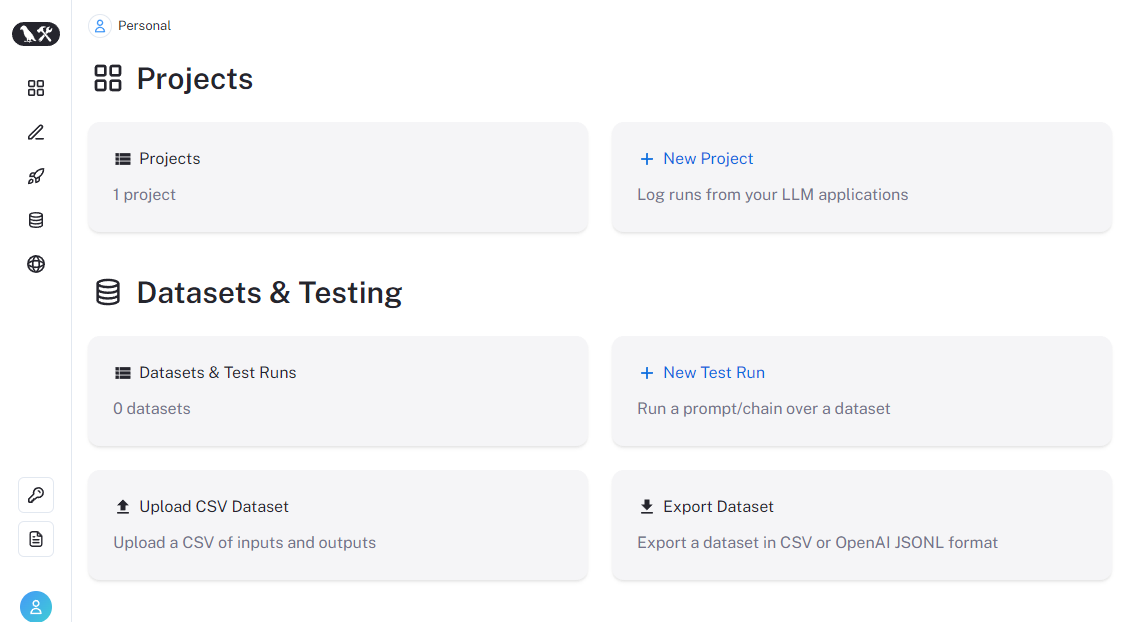

The two main sections are projects and datasets & testing and both sections can be manipulated through Python SDK. For now, let's create a new project by pressing on "+ New Project":

![](images/creating_projects.gif)

Once you click submit, the project will show up in the projects tab. Here is what it looks like:

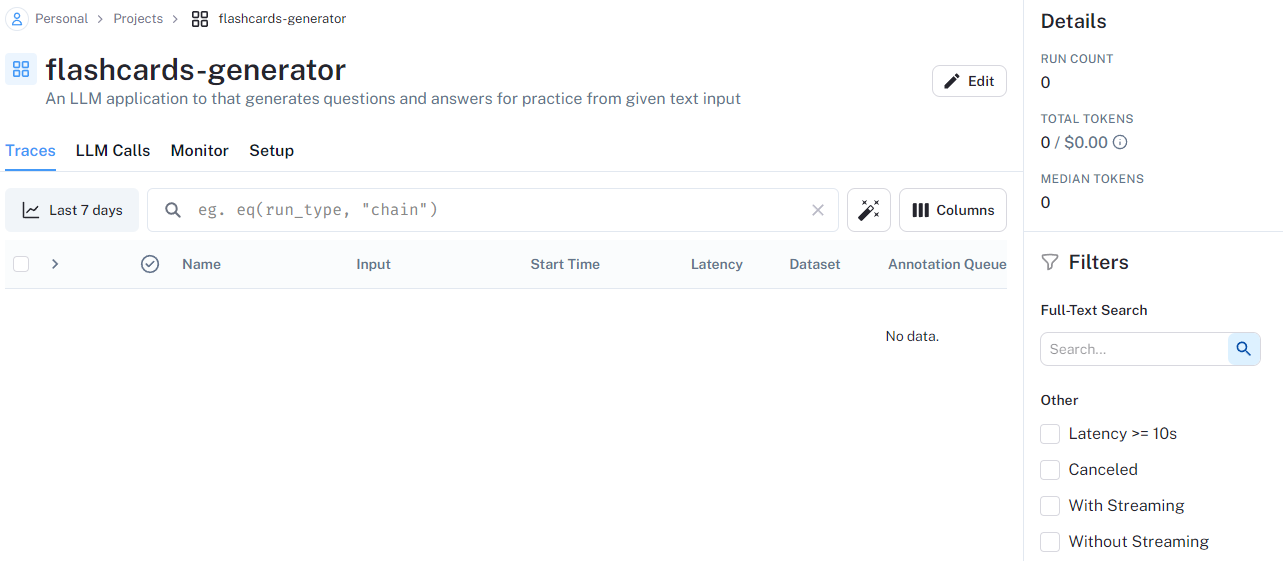

It is empty now, since we didn't log any runs. Let's do that.

## Setting up LangSmith Python SDK

To log runs with LLMs, you must create an API key (the key icon from the web UI) and save it somewhere safe. Then, in a new directory with a new virtual environment initialized, create a .env file. Inside, paste the following two lines:

```toml
LANGCHAIN_API_KEY="LangSmith-API-key"
OPENAI_API_KEY=Yoour-OPENAI-keyU"
```

Then, in your terminal, run the following commands to install LangSmith and `python-dotenv` to read environment variables.

```
pip install -U langsmith
pip install python-dotenv
```

Now, time to write code:

In [1]:
import warnings

from dotenv import find_dotenv, load_dotenv
from langchain.chat_models import ChatOpenAI
from langsmith import Client

warnings.filterwarnings("ignore")

> Hint: Run "Explain code" button to learn what each imported module does.

After importing relevant modules, we need to load the environment variables from `.env` and set some additional ones:

In [2]:
import os

load_dotenv(find_dotenv())
os.environ["LANGCHAIN_API_KEY"] = str(os.getenv("LANGCHAIN_API_KEY"))
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_PROJECT"] = "flashcards-generator"

The above code snippet will be the same for any LangSmith project - just change the project name to your own. 

In this project, we will use gpt-3.5 turbo since it is cheaper but you can use many other models available through `langchain`. Let's do our first run:

In [3]:
# Initialize a client
client = Client()

llm = ChatOpenAI()  # Uses gpt-3.5-turbo by default
llm.invoke("Hello, chatty, how you doin' today?")

AIMessage(content="Hello! As an AI, I don't have feelings, but I'm here to help you. How can I assist you today?")

First, we create a LangSmith client to communicate with the web UI platform. Then, we initialize an instance of `ChatOpenAI` client to talk to OpenAI models (gpt-3.5) by default. Then, to run a prompt, we simply call `.invoke`.

PASTE THE OUTPUT HERE.

If you quickly check the project from the UI, you will see the run logged:

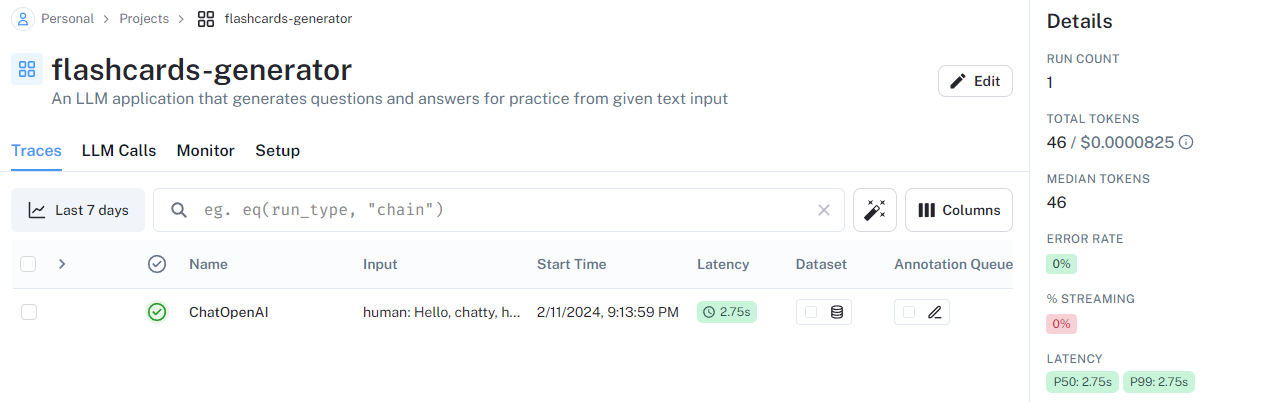

When we set up the environment variables and the client, we automatically enabled logging. As you can see, we already have a bunch of metadata about the run. 

![](images/first_run.gif)

Let's run a couple more prompts for fun:

In [4]:
message = llm.invoke("Do you know how to generate flashcards?")

message.content[:50]

'Yes, I can help you generate flashcards. Flashcard'

We can already build a basic text summarizer. Let's summarize the output of the last run:

In [6]:
prompt = f"Summarize this text: {message.content}"

summary = llm.invoke(prompt)
summary.content

'This text explains how to generate flashcards. It suggests different methods for creating flashcards, such as writing them by hand, using online flashcard generators, or using dedicated flashcard apps. The text provides a step-by-step guide on how to create flashcards, including determining the content, writing or typing the information, customizing the flashcards, printing them if desired, and using online flashcard generators. It emphasizes the importance of regularly reviewing and practicing with flashcards to enhance memory and understanding of the material.'

Great, now let's create our first dataset.

## Creating an unlabeled dataset in LangSmith

Datasets are one of the core components in LangSmith. Instead of running prompts (inputs) one-by-one like we did above, you will run them through datasets using parallelism. If your dataset contains outputs as well (desirable results, labels, you want the model to imitate), they will go into the dataset as well. 

LangSmith datasets can be of three types:

- [Key-value (`kv`)](https://docs.smith.langchain.com/evaluation/datasets#key-value-datasets) - default: Defines inputs as arbitrary key-value pairs. They are useful when evaluating chains and agents that require multiple inputs or return multiple outputs.
- [LLM datasets (`llm`)](https://docs.smith.langchain.com/evaluation/datasets#llm-datasets): Inputs and outputs are defined in "completion style" by LLMs - string in, string out.
- [Chat datasets (`chat`)](https://docs.smith.langchain.com/evaluation/datasets#chat-datasets): These are datasets converted from LLM chats and defined using structured inputs and serialized messages. 

First, let's see how to create a key-value dataset with no outputs. We will use the `create_dataset` function of the `client`:

In [7]:
dataset_name = "deep_learning_fundamentals"

# Creating a blank dataset
dl_dataset = client.create_dataset(
    dataset_name=dataset_name,
    description="A deck containing flashcards on NNs and PyTorch",
    data_type="kv",  # default
)

Now, let's add three inputs that each ask the LLM to create three flashcards:

In [9]:
# Storing only inputs into a dataset
example_inputs = [
    "Generate three flashcards on neural networks theory",
    "Generate three flashcards on how to create PyTorch models",
    "Generate three flashcards on how to evaluate PyTorch models",
]

for ex in example_inputs:
    # Each example input must be unique
    # The output is optional
    client.create_example(
        inputs={"input": ex},
        outputs=None,
        dataset_id=dl_dataset.id,
    )

If you go over the dataset tab of the UI, you will see each prompt listed with NULL output:

![](images/first_dataset.gif)

Now, let's run all the prompts in a single line of code using `run_on_dataset` function:

In [12]:
from langchain.smith import run_on_dataset

results = run_on_dataset(
    client=client,
    dataset_name=dataset_name,
    llm_or_chain_factory=llm,
)

View the evaluation results for project 'timely-boy-41' at:
https://smith.langchain.com/o/c50fc75b-a85e-5392-9845-1fd128ea9489/datasets/198305d0-e575-4548-86d8-835e52bb9bcc/compare?selectedSessions=6adf22c0-d2e8-4276-ad11-5624e25bd426

View all tests for Dataset deep_learning_fundamentals at:
https://smith.langchain.com/o/c50fc75b-a85e-5392-9845-1fd128ea9489/datasets/198305d0-e575-4548-86d8-835e52bb9bcc
[------------------------------------------------->] 3/3

Once the run finishes, it will be listed in the datasets tab. Here is how it looks like:

![](images/run_on_dataset1.gif)

If you inspect the output of each prompt, you will see structural differences in the cards. First output contains cards in format:

```
1. Flashcard: ...
Front: ...
Back: ...
```

The second one is in a completely different format and so is the third. Besides, the questions are too generic and easy to answer. So, let's address these issues. 

## Evaluating LLMs in LangSmith

OK, we've got three example prompts (examples) and we expect the LLM to return three flashcards for each. But how do we make sure that the model returns exactly three? Also, how do we force the format of questions generated into a schema? These are all problems we can solveby using evaluators in LangSmith.

We have no example outputs for example inputs, so we are kind of shooting in the dark. 

In [39]:
from langchain.smith import RunEvalConfig, run_on_dataset

# List the eval criteria
eval_config = RunEvalConfig(
    evaluators=[
        RunEvalConfig.Criteria("conciseness"),
    ]
)

run_on_dataset(
    client=client,
    dataset_name=dataset_name,
    llm_or_chain_factory=llm,
    evaluation=eval_config,
)

View the evaluation results for project 'sunny-book-50' at:
https://smith.langchain.com/o/c50fc75b-a85e-5392-9845-1fd128ea9489/datasets/62738028-4cec-4afa-a668-6fb5c958d0af/compare?selectedSessions=70b0de52-d719-4dd4-8203-3b94b6c0d75c

View all tests for Dataset deep_learning_fundamentals at:
https://smith.langchain.com/o/c50fc75b-a85e-5392-9845-1fd128ea9489/datasets/62738028-4cec-4afa-a668-6fb5c958d0af
[------------------------------------------------->] 3/3

{'project_name': 'sunny-book-50',
 'results': {'fa7135d9-4bce-42cc-a694-09708449913c': {'input': {'input': 'Generate three flashcards on how to evaluate PyTorch models'},
   'feedback': [EvaluationResult(key='conciseness', score=1, value='Y', comment='The criterion for this task is conciseness. This means the submission should be brief, to the point, and without unnecessary details or explanations.\n\nLooking at the submission, the AI has generated three flashcards on how to evaluate PyTorch models. Each flashcard is clear, direct, and provides the necessary information without going into unnecessary details.\n\nFlashcard 1 succinctly explains the purpose of evaluating PyTorch models. Flashcard 2 provides a brief overview of the common evaluation metrics for PyTorch models. Flashcard 3 explains how to evaluate PyTorch models using cross-validation in a concise manner.\n\nTherefore, the submission meets the criterion of conciseness.\n\nY', correction=None, evaluator_info={'__run': RunIn

In [34]:
from langchain.evaluation import Criteria

# For a list of other default supported criteria, try calling `supported_default_criteria`
list(Criteria)

[<Criteria.CONCISENESS: 'conciseness'>,
 <Criteria.RELEVANCE: 'relevance'>,
 <Criteria.CORRECTNESS: 'correctness'>,
 <Criteria.COHERENCE: 'coherence'>,
 <Criteria.HARMFULNESS: 'harmfulness'>,
 <Criteria.MALICIOUSNESS: 'maliciousness'>,
 <Criteria.HELPFULNESS: 'helpfulness'>,
 <Criteria.CONTROVERSIALITY: 'controversiality'>,
 <Criteria.MISOGYNY: 'misogyny'>,
 <Criteria.CRIMINALITY: 'criminality'>,
 <Criteria.INSENSITIVITY: 'insensitivity'>,
 <Criteria.DEPTH: 'depth'>,
 <Criteria.CREATIVITY: 'creativity'>,
 <Criteria.DETAIL: 'detail'>]

### Basic evaluators for unlabeled datasets

### Creating labeled datasets from various sources

### Writing custom evaluators

## Conclusion